# Warsaw Air Pollution

<span style="color: gray; font-size:1em;">Mateusz Zajac</span>
<br><span style="color: gray; font-size:1em;">Jul-2020</span>


## Table of Contents
- [Part I - Log Transformation](#log)
- [Part II - Lag Features](#lag)
- [Part III - Rolling Mean Features](#roll)
- [Part IV - Mean & Median Aggregations](#mm)
- [Part V - Dummy Features](#mm)

In [1]:
import pandas as pd
import numpy as np

import datetime
import calendar
import itertools

#visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
base_color = sns.color_palette()[0]

import warnings
warnings.filterwarnings('ignore')

#show all columns and rows
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [2]:
df = pd.read_hdf('data/warsaw_air_pollution_2015-2019.h5')

In [3]:
df.head()

,datetime,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,summary,temperature,uvIndex,visibility,windBearing,windSpeed,PM25_nie,PM25_wok,hour,day,dayofyear,weekday,month,year,IsWeekend,season,PM25_nie_mean,PM25_wok_mean
0,2015-01-01 00:00:00,32.93,1.0,29.56,0.87,unknown,0.0,0.0,1027.7,unknown,32.93,0.0,2.733,260.0,6.93,51.5034,51.320000,0,1,1,3,1,2015,0,Winter,41.406660,37.978489
1,2015-01-01 01:00:00,33.90,1.0,31.11,0.89,unknown,0.0,0.0,1027.7,unknown,33.90,0.0,2.733,260.0,6.93,71.8204,68.982316,1,1,1,3,1,2015,0,Winter,58.400547,60.969357
2,2015-01-01 02:00:00,27.73,1.0,31.59,0.91,cloudy,0.0,0.0,1027.7,Overcast,33.81,0.0,2.733,260.0,6.93,42.6996,48.707108,2,1,1,3,1,2015,0,Winter,50.865866,42.960510
3,2015-01-01 03:00:00,27.73,1.0,32.76,0.96,fog,0.0,0.0,1027.7,Foggy,33.81,0.0,1.244,251.0,6.93,38.2824,37.986883,3,1,1,3,1,2015,0,Winter,43.679332,37.038594
4,2015-01-01 04:00:00,26.41,1.0,32.89,0.97,fog,0.0,0.0,1027.7,Foggy,33.73,0.0,1.152,251.0,8.96,35.4194,33.675489,4,1,1,3,1,2015,0,Winter,36.976514,32.364739


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43848 entries, 0 to 43847
Data columns (total 27 columns):
datetime               43848 non-null datetime64[ns]
apparentTemperature    43848 non-null float64
cloudCover             43848 non-null float64
dewPoint               43848 non-null float64
humidity               43848 non-null float64
icon                   43848 non-null object
precipIntensity        43848 non-null float64
precipProbability      43848 non-null float64
pressure               43848 non-null float64
summary                43848 non-null object
temperature            43848 non-null float64
uvIndex                43848 non-null float64
visibility             43848 non-null float64
windBearing            43848 non-null float64
windSpeed              43848 non-null float64
PM25_nie               43848 non-null float64
PM25_wok               43848 non-null float64
hour                   43848 non-null int64
day                    43848 non-null int64
dayofyear       

<a id='log'></a>
# Part I - Log Transformation

In [5]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(14,8))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=50,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()
    plt.show()

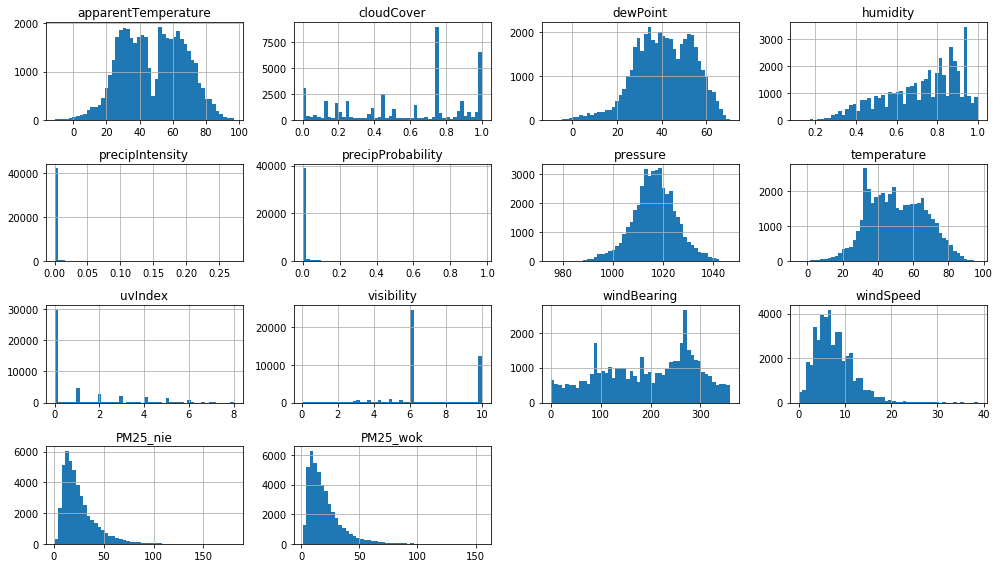

In [6]:
feats = ['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'precipIntensity', 
         'precipProbability', 'pressure', 'temperature', 'uvIndex', 'visibility',
         'windBearing', 'windSpeed', 'PM25_nie', 'PM25_wok']

draw_histograms(df, feats, 4, 4)

In [7]:
# getting log1p for PM25 and 2 other skewed distributions, that seems to be important
# while looking at the correlation matrix

log_feats = ['humidity', 'windSpeed', 'PM25_nie', 'PM25_wok']

for feat in log_feats:
    df['{}_log'.format(feat)] = np.log1p(df[feat].values)
    

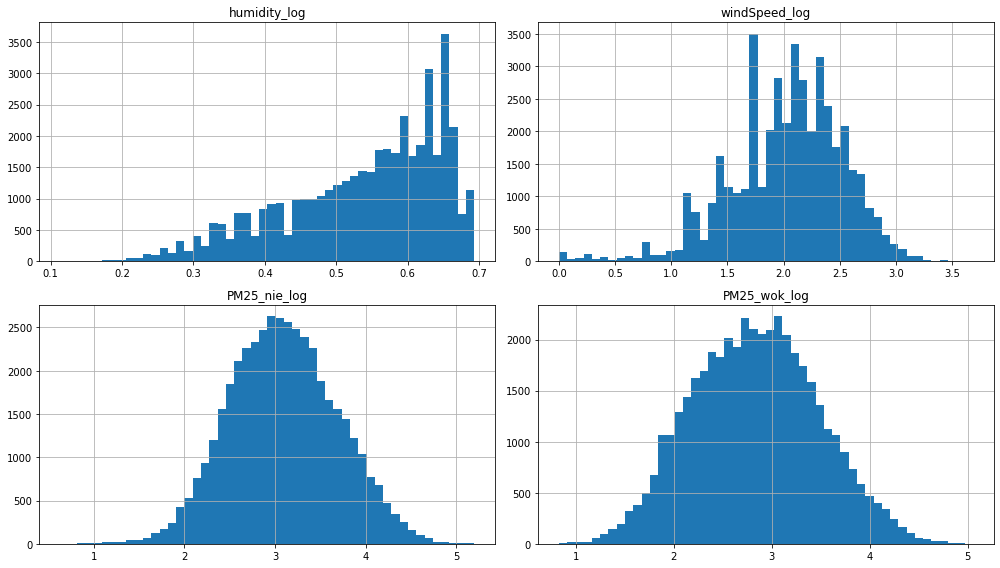

In [8]:
log_feats = ['humidity_log', 'windSpeed_log', 'PM25_nie_log', 'PM25_wok_log']

draw_histograms(df, log_feats, 2, 2)

<a id='lag'></a>
# Part II - Lag Features

In [9]:
# create 1h and 24h lags
feats = ['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'precipIntensity', 
         'precipProbability', 'pressure', 'temperature', 'uvIndex', 'visibility',
         'windBearing', 'windSpeed']
lags = [1, 24]

for lag in lags:
    for feat in feats:
        df['{0}_lag{1}h'.format(feat, lag)] = df[feat].shift(lag).astype('float32')

In [10]:
# backfill missing values
lag_cols = [col for col in df.columns if 'lag' in col]

for col in lag_cols:
    df[col] = df[col].fillna(method ='bfill')

<a id='roll'></a>
# Part III - Rolling Mean Features

In [11]:
feats = ['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'precipIntensity', 
         'precipProbability', 'pressure', 'temperature', 'uvIndex', 'visibility',
         'windBearing', 'windSpeed']
rolls = [12, 24, 168]

# create rolling means
for roll in rolls:
    for feat in feats:
        df['{0}_rolling{1}h'.format(feat, roll)] = df[feat].rolling(roll).mean()

In [12]:
# backfill missing values
rolling_cols = [col for col in df.columns if 'rolling' in col]

for col in rolling_cols:
    df[col] = df[col].fillna(method ='bfill')

In [13]:
df.head()

,datetime,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,summary,temperature,uvIndex,visibility,windBearing,windSpeed,PM25_nie,PM25_wok,hour,day,dayofyear,weekday,month,year,IsWeekend,season,PM25_nie_mean,PM25_wok_mean,humidity_log,windSpeed_log,PM25_nie_log,PM25_wok_log,apparentTemperature_lag1h,cloudCover_lag1h,dewPoint_lag1h,humidity_lag1h,precipIntensity_lag1h,precipProbability_lag1h,pressure_lag1h,temperature_lag1h,uvIndex_lag1h,visibility_lag1h,windBearing_lag1h,windSpeed_lag1h,apparentTemperature_lag24h,cloudCover_lag24h,dewPoint_lag24h,humidity_lag24h,precipIntensity_lag24h,precipProbability_lag24h,pressure_lag24h,temperature_lag24h,uvIndex_lag24h,visibility_lag24h,windBearing_lag24h,windSpeed_lag24h,apparentTemperature_rolling12h,cloudCover_rolling12h,dewPoint_rolling12h,humidity_rolling12h,precipIntensity_rolling12h,precipProbability_rolling12h,pressure_rolling12h,temperature_rolling12h,uvIndex_rolling12h,visibility_rolling12h,windBearing_rolling12h,windSpeed_rolling12h,apparentTemperature_rolling24h,cloudCover_rolling24h,dewPoint_rolling24h,humidity_rolling24h,precipIntensity_rolling24h,precipProbability_rolling24h,pressure_rolling24h,temperature_rolling24h,uvIndex_rolling24h,visibility_rolling24h,windBearing_rolling24h,windSpeed_rolling24h,apparentTemperature_rolling168h,cloudCover_rolling168h,dewPoint_rolling168h,humidity_rolling168h,precipIntensity_rolling168h,precipProbability_rolling168h,pressure_rolling168h,temperature_rolling168h,uvIndex_rolling168h,visibility_rolling168h,windBearing_rolling168h,windSpeed_rolling168h
0,2015-01-01 00:00:00,32.93,1.0,29.56,0.87,unknown,0.0,0.0,1027.7,unknown,32.93,0.0,2.733,260.0,6.93,51.5034,51.320000,0,1,1,3,1,2015,0,Winter,41.406660,37.978489,0.625938,2.070653,3.960878,3.957379,32.930000,1.0,29.559999,0.87,0.0,0.0,1027.699951,32.930000,0.0,2.733,260.0,6.93,32.93,1.0,29.559999,0.87,0.0,0.0,1027.699951,32.93,0.0,2.733,260.0,6.93,28.5625,0.999167,33.065,0.955,0.0,0.0,1027.802778,34.245,0.0,1.497083,262.5,8.1875,28.372083,0.884583,32.77875,0.922917,0.0,0.0,1027.697222,34.817083,0.0,3.255,268.5,8.880417,21.833036,0.65503,24.675714,0.777679,0.0,0.0,1020.708333,31.03006,0.005952,5.732369,231.767857,12.58
1,2015-01-01 01:00:00,33.90,1.0,31.11,0.89,unknown,0.0,0.0,1027.7,unknown,33.90,0.0,2.733,260.0,6.93,71.8204,68.982316,1,1,1,3,1,2015,0,Winter,58.400547,60.969357,0.636577,2.070653,4.287996,4.248243,32.930000,1.0,29.559999,0.87,0.0,0.0,1027.699951,32.930000,0.0,2.733,260.0,6.93,32.93,1.0,29.559999,0.87,0.0,0.0,1027.699951,32.93,0.0,2.733,260.0,6.93,28.5625,0.999167,33.065,0.955,0.0,0.0,1027.802778,34.245,0.0,1.497083,262.5,8.1875,28.372083,0.884583,32.77875,0.922917,0.0,0.0,1027.697222,34.817083,0.0,3.255,268.5,8.880417,21.833036,0.65503,24.675714,0.777679,0.0,0.0,1020.708333,31.03006,0.005952,5.732369,231.767857,12.58
2,2015-01-01 02:00:00,27.73,1.0,31.59,0.91,cloudy,0.0,0.0,1027.7,Overcast,33.81,0.0,2.733,260.0,6.93,42.6996,48.707108,2,1,1,3,1,2015,0,Winter,50.865866,42.960510,0.647103,2.070653,3.777339,3.906148,33.900002,1.0,31.110001,0.89,0.0,0.0,1027.699951,33.900002,0.0,2.733,260.0,6.93,32.93,1.0,29.559999,0.87,0.0,0.0,1027.699951,32.93,0.0,2.733,260.0,6.93,28.5625,0.999167,33.065,0.955,0.0,0.0,1027.802778,34.245,0.0,1.497083,262.5,8.1875,28.372083,0.884583,32.77875,0.922917,0.0,0.0,1027.697222,34.817083,0.0,3.255,268.5,8.880417,21.833036,0.65503,24.675714,0.777679,0.0,0.0,1020.708333,31.03006,0.005952,5.732369,231.767857,12.58
3,2015-01-01 03:00:00,27.73,1.0,32.76,0.96,fog,0.0,0.0,1027.7,Foggy,33.81,0.0,1.244,251.0,6.93,38.2824,37.986883,3,1,1,3,1,2015,0,Winter,43.679332,37.038594,0.672944,2.070653,3.670777,3.663225,27.730000,1.0,31.590000,0.91,0.0,0.0,1027.699951,33.810001,0.0,2.733,260.0,6.93,32.93,1.0,29.559999,0.87,0.0,0.0,1027.699951,32.93,0.0,2.733,260.0,6.93,28.5625,0.999167,33.065,0.955,0.0,0.0,1027.802778,34.245,0.0,1.497083,262.5,8.1875,28.372083,0.884583,32.77875,0.922917,0.0,0.0,1027.697222,34.817083,0.0,3.255,268

<a id='mm'></a>
# Part IV - Mean & Median Aggregations

In [14]:
# create mean and median per day for the below features

feats = ['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'precipIntensity', 
         'precipProbability', 'pressure', 'temperature', 'uvIndex', 'visibility',
         'windBearing', 'windSpeed']
aggreg = ['mean', 'median']


# group by day, then compute mean and median value
dfs_day = []

for aggs in aggreg:
    for feat in feats:
        globals()['{0}_{1}_per_day'.format(aggs, feat)] = df.groupby('dayofyear')[feat].agg(aggs).reset_index()
        dfs_day.append(globals()['{0}_{1}_per_day'.format(aggs, feat)])


# group by month, then compute mean and median value
dfs_month = []

for aggs in aggreg:
    for feat in feats:
        globals()['{0}_{1}_per_month'.format(aggs, feat)] = df.groupby('month')[feat].agg(aggs).reset_index()
        dfs_month.append(globals()['{0}_{1}_per_month'.format(aggs, feat)])
        

In [15]:
# assign meaningful column names
for aggs in aggreg:
    for feat in feats:
        globals()['{0}_{1}_per_day'.format(aggs, feat)].rename(columns={feat: '{0}_{1}_per_day'.format(aggs, feat)}, inplace=True)
        globals()['{0}_{1}_per_month'.format(aggs, feat)].rename(columns={feat: '{0}_{1}_per_month'.format(aggs, feat)}, inplace=True)       

In [17]:
# merge dataframes
for x in dfs_day:
    df = pd.merge(df, x, on='dayofyear', how='left')

In [18]:
# merge dataframes
for y in dfs_month:
    df = pd.merge(df, y, on='month', how='left')

In [19]:
df.head()

,datetime,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,summary,temperature,uvIndex,visibility,windBearing,windSpeed,PM25_nie,PM25_wok,hour,day,dayofyear,weekday,month,year,IsWeekend,season,PM25_nie_mean,PM25_wok_mean,humidity_log,windSpeed_log,PM25_nie_log,PM25_wok_log,apparentTemperature_lag1h,cloudCover_lag1h,dewPoint_lag1h,humidity_lag1h,precipIntensity_lag1h,precipProbability_lag1h,pressure_lag1h,temperature_lag1h,uvIndex_lag1h,visibility_lag1h,windBearing_lag1h,windSpeed_lag1h,apparentTemperature_lag24h,cloudCover_lag24h,dewPoint_lag24h,humidity_lag24h,precipIntensity_lag24h,precipProbability_lag24h,pressure_lag24h,temperature_lag24h,uvIndex_lag24h,visibility_lag24h,windBearing_lag24h,windSpeed_lag24h,apparentTemperature_rolling12h,cloudCover_rolling12h,dewPoint_rolling12h,humidity_rolling12h,precipIntensity_rolling12h,precipProbability_rolling12h,pressure_rolling12h,temperature_rolling12h,uvIndex_rolling12h,visibility_rolling12h,windBearing_rolling12h,windSpeed_rolling12h,apparentTemperature_rolling24h,cloudCover_rolling24h,dewPoint_rolling24h,humidity_rolling24h,precipIntensity_rolling24h,precipProbability_rolling24h,pressure_rolling24h,temperature_rolling24h,uvIndex_rolling24h,visibility_rolling24h,windBearing_rolling24h,windSpeed_rolling24h,apparentTemperature_rolling168h,cloudCover_rolling168h,dewPoint_rolling168h,humidity_rolling168h,precipIntensity_rolling168h,precipProbability_rolling168h,pressure_rolling168h,temperature_rolling168h,uvIndex_rolling168h,visibility_rolling168h,windBearing_rolling168h,windSpeed_rolling168h,mean_apparentTemperature_per_day,mean_cloudCover_per_day,mean_dewPoint_per_day,mean_humidity_per_day,mean_precipIntensity_per_day,mean_precipProbability_per_day,mean_pressure_per_day,mean_temperature_per_day,mean_uvIndex_per_day,mean_visibility_per_day,mean_windBearing_per_day,mean_windSpeed_per_day,median_apparentTemperature_per_day,median_cloudCover_per_day,median_dewPoint_per_day,median_humidity_per_day,median_precipIntensity_per_day,median_precipProbability_per_day,median_pressure_per_day,median_temperature_per_day,median_uvIndex_per_day,median_visibility_per_day,median_windBearing_per_day,median_windSpeed_per_day,mean_apparentTemperature_per_month,mean_cloudCover_per_month,mean_dewPoint_per_month,mean_humidity_per_month,mean_precipIntensity_per_month,mean_precipProbability_per_month,mean_pressure_per_month,mean_temperature_per_month,mean_uvIndex_per_month,mean_visibility_per_month,mean_windBearing_per_month,mean_windSpeed_per_month,median_apparentTemperature_per_month,median_cloudCover_per_month,median_dewPoint_per_month,median_humidity_per_month,median_precipIntensity_per_month,median_precipProbability_per_month,median_pressure_per_month,median_temperature_per_month,median_uvIndex_per_month,median_visibility_per_month,median_windBearing_per_month,median_windSpeed_per_month
0,2015-01-01 00:00:00,32.93,1.0,29.56,0.87,unknown,0.0,0.0,1027.7,unknown,32.93,0.0,2.733,260.0,6.93,51.5034,51.320000,0,1,1,3,1,2015,0,Winter,41.406660,37.978489,0.625938,2.070653,3.960878,3.957379,32.930000,1.0,29.559999,0.87,0.0,0.0,1027.699951,32.930000,0.0,2.733,260.0,6.93,32.93,1.0,29.559999,0.87,0.0,0.0,1027.699951,32.93,0.0,2.733,260.0,6.93,28.5625,0.999167,33.065,0.955,0.0,0.0,1027.802778,34.245,0.0,1.497083,262.5,8.1875,28.372083,0.884583,32.77875,0.922917,0.0,0.0,1027.697222,34.817083,0.0,3.255,268.5,8.880417,21.833036,0.65503,24.675714,0.777679,0.0,0.0,1020.708333,31.03006,0.005952,5.732369,231.767857,12.58,29.673403,0.703438,30.910208,0.820625,0.001033,0.029861,1016.38912,35.949792,0.0,6.1025,212.916667,8.614931,30.76,0.75,33.73,0.83,0.0,0.0,1016.232609,36.925,0.0,6.216,223.0,7.595,23.315924,0.700556,25.432738,0.836071,0.000674,0.022361,1015.459669,29.965072,0.076122,5.640179,195.026175,8.034874,24.855,0.75,27.9,0.86,0.0,0.0,1016.5,31.94,0.0,6.215,207.5,7.465
1,2015-01-01 01:00:00,33.90,1.0,31.11,0.89,unknown,0.0,0.0,1027.7,unknown,33.90,0.0,2.733,260.0,6.93,7

In [24]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43848 entries, 0 to 43847
Data columns (total 139 columns):
datetime                                datetime64[ns]
apparentTemperature                     float64
cloudCover                              float64
dewPoint                                float64
humidity                                float64
icon                                    object
precipIntensity                         float64
precipProbability                       float64
pressure                                float64
summary                                 object
temperature                             float64
uvIndex                                 float64
visibility                              float64
windBearing                             float64
windSpeed                               float64
PM25_nie                                float64
PM25_wok                                float64
hour                                    int64
day                    

In [ ]:
# get dummies
df = pd.get_dummies(data=df, columns=['season'], drop_first=True)

# assign meaningful column names
df.rename(columns={'season_Autumn':'Autumn', 'season_Spring':'Spring', 
                           'season_Summer':'Summer', 'season_Winter':'Winter'}, inplace=True)

In [ ]:
## save dataframes to hdf
train_copy.to_hdf('../output/train_air_china.h5', key='train_copy', format='t')